## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


from evaluator import evaluate, compute_threshold
from dataloader import loader


# from sklearn.metrics import confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

2023-02-16 14:17:46.055496: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

We will use the SMAP data sets for training and testing.

You can find raw data in https://s3-us-west-2.amazonaws.com/telemanom/data.ziphttps://s3-us-west-2.amazonaws.com/telemanom/data.zip

I used preprocessed datasets with 25 dimensions.

You can find preprocessed data in https://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRmhttps://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRm

In [2]:
df_train, df_test, df_test_label = loader(dataset="SMD")

## Prepare training data


In [3]:
# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
df_test_value = pd.DataFrame(scaler.transform(df_test))
print("Number of training samples:", len(df_training_value))
print("Number of training samples:", len(df_test_value))

Number of training samples: 28479
Number of training samples: 28479


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [4]:
TIME_STEPS = 100


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Training input shape:  (28380, 100, 38)
Test input shape:  (28380, 100, 38)


## Build a model


In [5]:
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.GRU(64, return_sequences=True),
        layers.GRU(32),
        layers.RepeatVector(x_train.shape[1]),
        layers.GRU(32, return_sequences=True),
        layers.GRU(64),
        layers.Dense(x_train.shape[1] * x_train.shape[2]),
        layers.Reshape([x_train.shape[1], x_train.shape[2]]),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

2023-02-16 14:17:47.652578: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-16 14:17:47.700062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-16 14:17:47.700098: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-16 14:17:47.702938: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-16 14:17:47.703010: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-16 14:17:47.703859: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 64)           19968     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 32)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 32)           6336      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 3800)              247000    
_________________________________________________________________
reshape (Reshape)            (None, 100, 38)           0

## Train the model


In [6]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

2023-02-16 14:17:49.553446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-16 14:17:49.571907: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/50


2023-02-16 14:17:52.778483: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-16 14:17:53.552657: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-02-16 14:17:53.756060: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-16 14:17:54.319544: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-16 14:17:54.319614: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


178/178 [==============================] - 11s 32ms/step - loss: 0.3626 - val_loss: 0.2968
Epoch 2/50
178/178 [==============================] - 5s 27ms/step - loss: 0.2529 - val_loss: 0.2567
Epoch 3/50
178/178 [==============================] - 5s 27ms/step - loss: 0.2208 - val_loss: 0.2470
Epoch 4/50
178/178 [==============================] - 5s 28ms/step - loss: 0.2059 - val_loss: 0.2416
Epoch 5/50
178/178 [==============================] - 5s 25ms/step - loss: 0.1985 - val_loss: 0.2349
Epoch 6/50
178/178 [==============================] - 5s 28ms/step - loss: 0.1930 - val_loss: 0.2305
Epoch 7/50
178/178 [==============================] - 5s 26ms/step - loss: 0.1890 - val_loss: 0.2275
Epoch 8/50
178/178 [==============================] - 5s 27ms/step - loss: 0.1863 - val_loss: 0.2246
Epoch 9/50
178/178 [==============================] - 5s 25ms/step - loss: 0.1840 - val_loss: 0.2202
Epoch 10/50
178/178 [==============================] - 5s 27ms/step - loss: 0.1819 - val_loss: 0.2199

Let's plot training and validation loss to see how the training went.

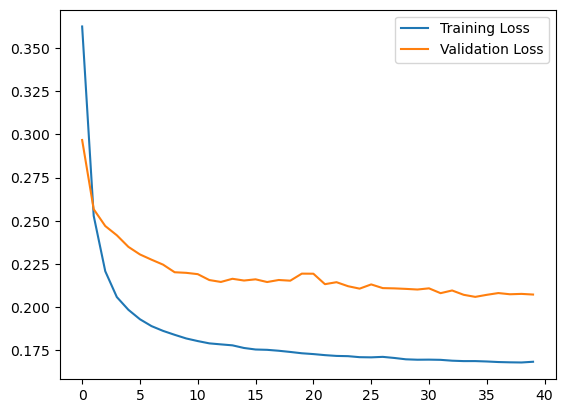

In [7]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies
### We could set threshold my using train loss, and detect which points are anomalies

In [8]:
# Get prediction of train data
x_train_pred = model.predict(x_train)
print("Predict train data done")

# Get test MAE loss.
x_test_pred = model.predict(x_test)
print("Predict test data done")

Predict train data done
Predict test data done


In [9]:
thresholds = {
    "abs_mean": compute_threshold(x_train, x_train_pred, option="abs_mean"),
    "abs_median": compute_threshold(x_train, x_train_pred, option="abs_median"),
    "abs_max": compute_threshold(x_train, x_train_pred, option="abs_max"),
    "square_mean": compute_threshold(x_train, x_train_pred, option="square_mean"),
    "square_median": compute_threshold(x_train, x_train_pred, option="square_median"),
    "rank": compute_threshold(x_train, x_train_pred, option="rank", label=df_test_label["label"]),
}
print(f'abs mean threshold: {thresholds["abs_mean"]:.3f}')
print(f'abs median threshold: {thresholds["abs_median"]:.3f}')
print(f'abs max threshold: {thresholds["abs_max"]:.3f}')
print(f'square mean threshold: {thresholds["square_mean"]:.3f}')
print(f'square median threshold: {thresholds["square_median"]:.3f}')
print(f'rank threshold: {thresholds["rank"]:.3f}')

# Detect all the samples which are anomalies.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
# anomalies = np.sum(test_mae_loss, axis=1) > threshold

abs mean threshold: 7.136
abs median threshold: 6.747
abs max threshold: 30.577
square mean threshold: 6.669
square median threshold: 4.438
rank threshold: 8.684


threshold: 30.577


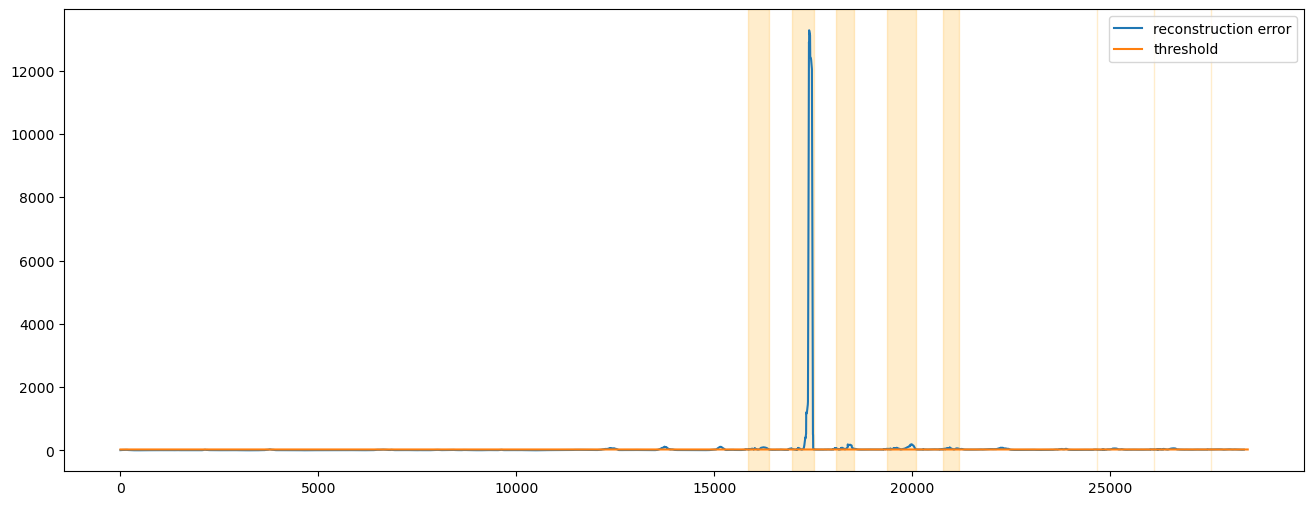

In [10]:
# Choose the lowest loss of the anomaly datas((# of anomalies)th) as threshold by using rank option
threshold = thresholds["abs_max"]
print(f"threshold: {threshold:.3f}")

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label["label"].values.tolist()
dates = df_test.index


pd.DataFrame(np.sum(test_mae_loss, axis=1)).plot(ax=ax)
pd.DataFrame([threshold] * len(df_test)).plot(ax=ax)
ax.legend(["reconstruction error", "threshold"], loc="upper right")


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == True:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label == True:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")

## Predict & Evaluation


## #1 if any included time step has anomalies => abnormal

In [16]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["abs_max"]
print("Number of anomaly samples: ", np.sum(anomalies))

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print("Number of anomalous samples: ", len(anomalous_data_indices))

test_pred = np.zeros(len(df_test))
test_label = df_test_label["label"]
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  7011
Number of anomalous samples:  4241
accuracy: 89.76%
precision: 47.39%
recall: 74.61%
f1: 57.97%


## #2 If half of included time steps has anomaly => abnormal

In [12]:
# data i is an anomaly if ratio of anomalies sequences/involved total sequences >= 0.5
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["abs_max"]
test_anomalies = np.zeros(len(df_test))
test_seqs = np.zeros(len(df_test))
test_label = df_test_label["label"]
print("Number of anomaly samples: ", np.sum(anomalies))

for idx, anomaly in enumerate(anomalies):
    test_seqs[idx : min(idx + TIME_STEPS, len(df_test))] += 1
    if anomaly:
        test_anomalies[idx : min(idx + TIME_STEPS, len(df_test))] += 1
test_pred_ratio = np.divide(test_anomalies, test_seqs)
test_pred = test_pred_ratio >= 0.5
print("Number of anomalous samples: ", sum(test_pred))


accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  7011
Number of anomalous samples:  6987
accuracy: 84.41%
precision: 37.51%
recall: 97.29%
f1: 54.15%


In [13]:
idx = 4690
evaluation_array = [(test_seqs - test_anomalies)[idx:idx+400],
                    test_anomalies[idx:idx+400],
                    test_seqs[idx:idx+400],
                    test_pred_ratio[idx:idx+400],
                    test_pred[idx:idx+400],
                    df_test_label["label"][idx:idx+400]]

df = pd.DataFrame(evaluation_array, dtype=float)
df.index = ['Normal', 'Anomaly', '#Seq', 'Pred(%)', 'Pred', 'GT']
df.style.background_gradient(cmap='summer', axis=1)

### #3 we could find the threshold with highest f1 score by calculating all cases 


In [14]:
from evaluator import evaluate

label = create_sequences(df_test_label["label"], TIME_STEPS)
print(label.shape)
scores = evaluate(x_test, x_test_pred, label, n=10, scoring="abs_mean")

(28380, 100)


In [15]:
# print("f1:",np.max(scores['f1']))
idx = np.argmax(scores["f1"])

print(f"threshold: {scores['thresholds'][idx]}")
print(f"precision: {scores['precision'][idx]*100:.2f}%")
print(f"recall: {scores['recall'][idx]*100:.2f}%")
print(f"f1: {scores['f1'][idx]*100:.2f}%")

threshold: 0.0
precision: 12.28%
recall: 100.00%
f1: 21.88%
